# Oblig stk4021
Simen Eide

## Load data and libraries

In [1]:
import pandas as pd
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
raw = pd.read_csv("fr1_data")
raw.head(2)

,Unnamed: 0,name,birth,death,term.start,term.end,executed,girondin,number.languages
0,1,Jerome Petion de Villeneuve,1756.008333,1794.466667,1792.722222,1792.761111,1,1,15
1,2,Jean-Francois Delacroix,1753.258333,1794.263889,1792.761111,1792.800000,1,0,4


## Part 1 - Life-length after presidency

### a)
Find the data and define the variable y as specified above. Display a
histogram of these time points. The histogram should look like the one
displayed in Figure 1.

---

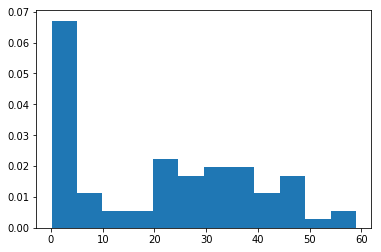

In [2]:
raw['postpres'] = raw['death'] - raw['term.end']
y = raw['postpres'].values
_ = plt.hist(y, density=True, bins = 12)

### b)

Find the density of the two-parameter weibull model. CDF:

---

$$ F(y|a,b) = 1 - e^{-(y/a)^{b})} $$

Get density by taking derivative w.r.t. y:
$$ \frac{dF}{dy} = -exp(-(y/a)^{b})) (-b) (\frac{y}{a})^{b-1} (\frac{1}{a}) $$

Rearranging:
$$ f(y |a,b) = \frac{dF}{dy} = e^{-(y/a)^{b}} (\frac{by^{b-1}}{a^b}) $$


## c) 
We are Bayesian statisticians today, and we need to specify a prior for
the unknown parameters a and b above. Assume first that we have not
yet managed to get hold of a suitable expert, and that we therefore wish
to use the ‘non-informative’ Jeffreys prior for the Weibull model. Show
that the Jeffreys prior, p0(a, b), is proportional to 1/a.

---

## d)
Assume now (for simplicity) that the parameter b happens to be known
and equal to 0.9. 

- Find the posterior distribution for a using Jeffreys prior
above. Here you may find it useful to use some numerical integration
routine, for instance integrate in R. 
- Display the posterior density for
a and find the posterior mode. 
- Use this point-estimate for a to display
the estimated Weibull density curve along with the histogram of the
data. This should look like Figure 1. 
- Comment briefly on how you think
the model fits the data.

----
The likelihood

$$ P(y|a,b) = \prod_{i=1}^{73} e^{-(y_i/a)^{b}} (\frac{by_i^{b-1}}{a^b}) $$

The posterior is propotional to

$$ P(a|y) \propto P(y |a,b) * \frac{1}{a} $$

We can find the normalizing constant by numerically integrating $P(a|y)$ by monte carlo integration:

In [4]:
# Define non-normalized prior, likelihood and posterior:

def weibull_density(y,a,b):
    return np.exp(-(y/a)**b) * b * y**(b-1) / a**b

b0 = 0.9
def nonnorm_likelihood(a, b = b0): 
    l = weibull_density(y,a,b)
    return l.prod()

def nonnorm_prior(a,b = b0):
    return 1/a

nonnorm_posterior = lambda a: nonnorm_likelihood(a,b0)*nonnorm_prior(a,b0)
nonnorm_posterior = np.vectorize(nonnorm_posterior)

In [5]:
## Integrate to get posterior:
def mc_integrate(f, low = 0, high = 1, samples = 100000):
    u = np.random.uniform(low = low, high = high, size=samples)
    pmf = f(u)*(high-low)
    return np.mean(pmf)

const = mc_integrate(nonnorm_posterior, low = 10, high = 30)
print(const)
posterior = lambda a: nonnorm_posterior(a)*1/const

5.277000105381629e-130


Visualize the posterior:


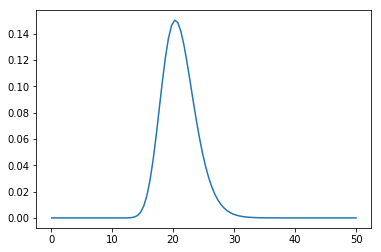

In [6]:
print('Visualize the posterior:')
a_ = np.linspace(0.1,50, 100)
p = posterior(a_)
_ = plt.plot(a_,p)

In [7]:
## Find the mode:
a_mode = a_[p.argmax()]
print("The mode of the posterior is {}.".format(a_mode))

The mode of the posterior is 20.261616161616164.


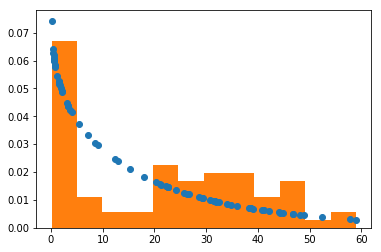

In [8]:
### Visualize the mode point estimate of the distribution
# Plot on same area as observed data
w_density = weibull_density(y,a = a_mode, b = 0.9)

plt.plot(y,w_density, "o")
_ = plt.hist(y, density=True, bins = 12)

#### Comments on model fit
The fit seems to work at either end of the scale, but there seems to be something wrong from y=5 to y=20.
It seems like quite a few of the leaders died shortly after their period terminated, whereas other lived for a long time.

### (e) 
The histogram of post-presidency life-times is rather unusual-looking,
and somewhat bimodal, therefore we will now attempt a more complex
model, a mixture of two Weibull distributions. The density takes the
following form,

g(y|a1, b1, a2, b2, ρ) = ρf(y|a1, b1) + (1 − ρ)f(y|a2, b2) for y > 0.

Here f(·) is the Weibull density function given in (b), a1, b1, a2 and b2
are positive parameters, and ρ is the mixture parameter, taking values
between 0 and 1. Programme the log-likelihood function
`n(a1, b1, a2, b2, ρ) = Xn
i=1
log g(yi
|a1, b1, a2, b2, ρ),
and find the maximum likelihood estimates for the n = 73 life-times
using a suitable numerical optimiser. Good starting values are important
in this case, you may use (2, 1, 35, 3, 0.5). Add the estimated density
curve to the same figure as in the previous question and comment briefly

In [9]:
def twoWeibullDensity(y, a1,b1,a2,b2,rho):
    return rho*weibull_density(y,a1,b1) + (1-rho)*weibull_density(y,a2,b2)


In [10]:
par0 = np.array([2,1,35,3,0.5])

In [11]:
lik = lambda par : sum(np.log(twoWeibullDensity(y,par[0],par[1],par[2],par[3],par[4])))

In [12]:
from scipy.optimize import minimize

In [13]:
opt = minimize(lambda par: -lik(par),par0, method='nelder-mead')
par = opt.x
par

array([ 2.31358752,  1.12873223, 36.58008183,  2.97417611,  0.36314301])

In [14]:
mle = twoWeibullDensity(y, par[0],par[1],par[2],par[3],par[4])

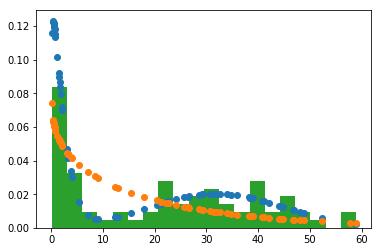

In [15]:
plt.plot(y,mle, "o")
plt.plot(y,w_density, "o")
_ = plt.hist(y, density=True, bins = 20)

The bimodal distribution seems to much better fit the data as it has a significant dip for $y \in (5,20)$.

### (f) 
Assume we have consulted with Mrs. Capet, an expert in revolutionary
history, and she has given us the following prior for the full parameter
vector $(a1, b1, a2, b2, ρ)$: 
let the five parameters be independent and
$$a1 ∼ Gamma(3, 1)$$
$$b1 ∼ Unif(0.5, 4)$$
$$a2 ∼ Gamma(20, 1)$$
$$b2 ∼ Gamma(10, 2)$$
$$p ∼ Beta(α, β) $$

Further, let the prior for ρ be a $Beta(α, β)$, such that $E(ρ) = 0.2$ and
$Var(ρ) = 0.04^2$. 

- Find the corresponding α, β values (if you do not
manage this part, use α = 2 and β = 5 in the following). 
- Using the prior
above, draw 1000 random post-presidency life-times from the associated
prior predictive distribution, and display them in a histogram. 
- Comment
briefly.


---


In [16]:
from scipy.stats.distributions import gamma, uniform, beta

In [17]:
### get beta distr with correct alpha and beta
p0 = np.array([2,5]) #initial cond.
f = lambda p: (beta.mean(p[0], p[1])- 0.2)**2 + (beta.var(p[0], p[1]) - 0.04**2)**2
opt = minimize(f, p0, tol = 1e-10, method='nelder-mead')
p = opt.x
print("ESTIMATE:")
print("alpha: {}, beta: {}".format(p[0],p[1]) )
print("gives mean {} and variance {}^2.".format(beta.mean(p[0], p[1]), np.sqrt(beta.var(p[0], p[1]))))

ESTIMATE:
alpha: 19.79999999999069, beta: 79.19999999996335
gives mean 0.1999999999999988 and variance 0.040000000000009105^2.


#### Draw 1000 from predictive distribution

First inverse the weibull so we can sample from it by using unif random:

$$ F^{-1}(X) = \alpha (-ln(1-X))^{1/b}$$

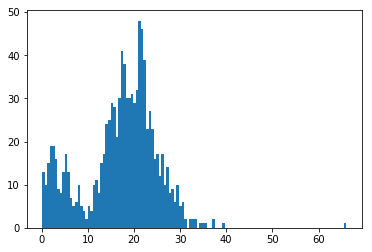

In [18]:
def weib_invcdf(x, a,b):
    return a*(-np.log(x))**(1/b)

n = 1000
a1_ = gamma.rvs(3,2, size=n)
b1_ = uniform.rvs(0.5,3.5, size=n) # seems like second argument is the added diff
a2_ = gamma.rvs(20,1, size=n)
b2_ = gamma.rvs(10,2, size=n)
rho_ = beta.rvs(p[0],p[1], size = n)

u = np.random.uniform(0,1,size = n)
u2 = np.random.uniform(0,1,size = n)
prior_sample = weib_invcdf(u,a1_,b1_)*(u2 < rho_) + (1-(u2 < rho_))*weib_invcdf(u,a2_,b2_)
_ = plt.hist(prior_sample, bins = 120)

The posterior has managed to get the shape of the real data fairly well, but seems to be a bit weak in the tails.

### (g) 
Set up an MCMC scheme in order to draw samples from the posterior
for (a1, b1, a2, b2, ρ) using the prior specified above. Display a histogram
of posterior draws for ρ. 

- Give the posterior mean and 95% posterior
interval for the following two quantities: 
 + λ, the probability of dying
within 5 years of the end of presidency, and 
 + γ, the probability of living
longer than 40 years after the end of presidency. Compare these results
with empirical estimates of λ and γ.

---
Likelihood is the twoWeibull distr
priors are the product of each prior distr (indep.)

In [19]:
# likelihood

lik = lambda par : (twoWeibullDensity(y,par[0],par[1],par[2],par[3],par[4])).prod()
prior = lambda par: gamma.pdf(par[0], 3,2) * uniform.pdf(par[1], 0.5,3.5) * gamma.pdf(par[2],20,1) * gamma.pdf(par[3],10,2)*beta.pdf(par[4],p[0],p[1])
posterior = lambda par: prior(par)*lik(par)

# This can be done in terms of loglikelihoods as well, gave same results
#  (remember to transform byexp etc in algorithms)
logprior = lambda par:  (
    np.log(gamma.pdf(par[0], 3,2)) + 
    np.log(uniform.pdf(par[1], 0.5,3.5)) +
    np.log(gamma.pdf(par[2],20,1)) +
    np.log(gamma.pdf(par[3],10,2)) +
    np.log(beta.pdf(par[4],p[0],p[1])) )

loglik = lambda par: np.sum(np.log(twoWeibullDensity(y,par[0],par[1],par[2],par[3],par[4])))
logpost = lambda par: logprior(par) + loglik(par)


In [20]:
## Metropolis-hastings
n = int(5e4)
parsize = 5
theta = np.zeros((n,parsize))
theta[0,] = par # start in mle point for simplification
for i in range(1,n):
    theta_candidate = theta[i-1,] + (uniform.rvs(size=5)-0.5)*0.1
    theta_candidate = theta_candidate.clip(min=0.001)
    ratio = posterior(theta_candidate)/posterior(theta[i-1,])
    prob_accept = min(1, ratio)
    if np.isnan(ratio):
        print("Found NAN value.")
        break
    
    accept = np.random.uniform() < prob_accept

    theta[i] = theta_candidate if accept else theta[i-1]

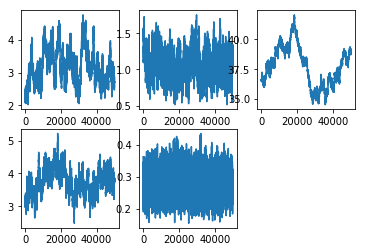

In [21]:
#### Get trajectories
for i in range(5):
    plt.subplot(2,3,i+1)
    _ = plt.plot(theta[:,i])

#### Histogram of rho

'E[rho | data, prior] = 0.2763'

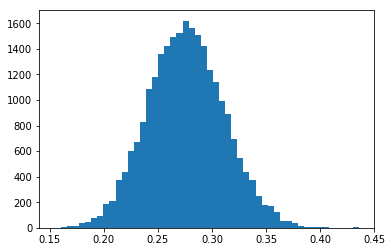

In [24]:
_ = plt.hist(theta[int(n/2):,4], bins = 50)
f"E[rho | data, prior] = {np.round(np.mean(theta[int(n/2):,4]),4)}"

##### Histogram of all

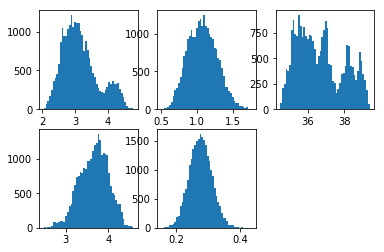

In [23]:
#### Get histograms
for i in range(5):
    plt.subplot(2,3,i+1)
    _ = plt.hist(theta[int(n/2):,i], bins = 50)

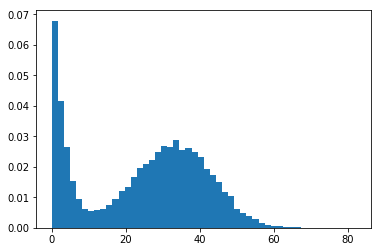

In [25]:
# Sample from posterior
# burnout half of trajectories:
post_samples = theta[int(n/2):]
n = post_samples.shape[0]
a1_ = post_samples[:,0]
b1_ = post_samples[:,1]
a2_ = post_samples[:,2]
b2_ = post_samples[:,3]
rho_ = post_samples[:,4]

def sample_one_post_predictive():
    u = np.random.uniform(0,1,size = n)
    u2 = np.random.uniform(0,1,size = n)
    post_pred = weib_invcdf(u,a1_,b1_)*(u2 < rho_) + (1-(u2 < rho_))*weib_invcdf(u,a2_,b2_)
    return post_pred

post_pred = sample_one_post_predictive()
_ = plt.hist(post_pred, bins = 50, density =True)

In [26]:
# prob dying within 5 years:
post_pred = sample_one_post_predictive()
print(f" The posterior probability of dying within 5 years: {np.mean(post_pred <=5)}")
print(f" The empirical probability of dying within 5 years: {np.mean(y <=5)}")

 The posterior probability of dying within 5 years: 0.2218
 The empirical probability of dying within 5 years: 0.3287671232876712


In [30]:
# prob dying within 5 years:
print(f" The posterior probability of living more than 40 years: {np.mean(post_pred >=40)}")
print(f" The empirical probability of living more than 40 years: {np.mean(y >=40)}")

 The posterior probability of living more than 40 years: 0.18236
 The empirical probability of living more than 40 years: 0.1780821917808219


### (h) 
When conducting statistical analyses our goal is often to make statements
about a certain unobserved population. Discuss briefly to what extent
the available dataset offers any possibility for such generalisations.

## Part 2 – Cause of death
While working with Part 1 you might have guessed that there are in fact
two groups of presidents in the dataset (or equivalently, that there are
two different processes governing the life lengths of the presidents): some presidents were executed during the revolution, while the rest survived the
revolutionary period and died of natural causes. Now we will look more
carefully at the cause of death, by studying the variable ‘executed’ which
indicates whether the president was executed (1), or not (0)2
.